<a href="https://colab.research.google.com/github/blingbling1996/PINN_Gildin/blob/main/Advection_Periodic_CINN_Share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Characteristics-Informed Neural Network Solution of the Advection Problem
 
This code is distributed under the GNU LGPL license.<br>
Last Modified: Jan 24 2023<br>

Author: Ulisses Braga-Neto <br>
Professor of Electrical and Computer Engineering<br>
Director of the TAMIDS Scientific Machine Learning Lab<br>
Texas A&M University<br>
https://sciml.tamids.tamu.edu/<br>
https://braganeto.engr.tamu.edu/<br>

This code demonstrates the application of characteristics-informed neural networks (CINN) to the the classical univariate advection of a tracer in a moving fluid, with a sinusoidal initial condition. 

The evolution of the tracer concentration $q(x,t)$ in a pipe, for $0 \leq x \leq L$ and $t>0$, is governed by the univariate linear advection hyperbolic PDE [1]:
  \begin{aligned}
  q_t + vq_x = 0
  \end{aligned}
where $v$ is the constant velocity. The initial condition is  
\begin{equation}
  q(x,0) = \sin(x)
\end{equation}
This simple problem has as solution:
\begin{aligned}
     q(x,t) = \sin(x-vt) 
  \end{aligned} 
In other words, the initial sinusoisal profile is simply advected to the left with speed $v$.

In this demo, we assume $L = 2\pi$ and $v = 1$. 

References:

[1] Randall J. LeVeque, Finite Volume Methods for Hyperbolic Problems. Cambridge University Press, 2002. 


In [ ]:
""""
PINN solution using direct implementation in Tensorflow (Adam training only)
"""

import numpy as np
import tensorflow as tf
import time
import math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

!pip -q install pyDOE
from pyDOE import lhs

In [ ]:
"""
Problem Definition and Analytical Solution
"""

# parameters of the simulation
L =  2*np.pi # channel length
T = 1.0 # simulation total time
v = 30.0 # advection speed

# define grid for solution
utn = 300
uxn = 300
xlo = 0
xhi = L
ux = np.linspace(xlo,xhi,uxn)
tlo = 0.0
thi = T
ut = np.linspace (tlo,thi,utn)
Xm,Tm = np.meshgrid(ux,ut)
XT_flat = np.hstack((Xm.flatten()[:,None],Tm.flatten()[:,None]))

# analytical solution 
u = np.zeros([uxn,utn])
for utj in range(utn):
  for uxj in range(uxn):
    u[uxj,utj] = np.sin(uxj*L/uxn-v*utj*T/utn) 
u_flat = u.T.flatten()

In [ ]:
# training functions

@tf.function
def grad(model,xlb,tlb,xub,tub,x0,t0,u0):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(model,xlb,tlb,xub,tub,x0,t0,u0)
        grads = tape.gradient(loss_value,nnet.trainable_variables)
    return loss_value, grads

def loss(model,xlb,tlb,xub,tub,x0,t0,u0):
    pred_0  = nnet(tf.concat([x0,t0],1))
    pred_lb = nnet(tf.concat([xlb,tlb],1))
    pred_ub = nnet(tf.concat([xub,tub],1))

    # IC loss
    mse_0 = tf.reduce_mean(tf.pow(u0-pred_0,2)) 

    # periodic boundary loss
    mse_b = tf.reduce_mean(tf.pow(pred_lb-pred_ub,2))

    return  mse_0+mse_b

In [ ]:
# network architecture

layer_sizes = [2]+[1]+4*[50]+[1]

def my_init(shape,dtype=None):
    w = tf.constant([1.0,-v],shape=shape)
    return w
    
def neural_net(layer_sizes):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(layer_sizes[0],)))
    model.add(layers.Dense(
            layer_sizes[1],activation=None,use_bias=False,
            kernel_initializer=my_init,trainable=False))
    for width in layer_sizes[2:-1]:
        model.add(layers.Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal",trainable=True))
    model.add(layers.Dense(
            layer_sizes[-1], activation=None,
            kernel_initializer="glorot_normal",trainable=True))
    return model

In [ ]:
# output functions

def plot_slices(U,U_pred,slices):
    fig = plt.figure(figsize=(12,2),dpi=65)
    ax = fig.add_subplot(111)
    ax.axis('off')
    gs1 = gridspec.GridSpec(1,len(slices))
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    for gi,snap in enumerate(slices):
        tind = int(snap*len(ut))
        ax = plt.subplot(gs1[0,gi])
        ax.plot(ux,U[:,tind],'b-',linewidth=2,label='Exact')       
        ax.plot(ux,U_pred[tind,:],'r--',linewidth=2,label='Prediction')
        ax.set_title('$t = %.2f$' % (ut[tind]),fontsize=10)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(t,x)$')
        ax.set_xlim([-0.1,L+0.1])
        ax.set_ylim([-1.1,1.1])
    plt.show()

def results(model,loss_value,tm):
    CINN = model(XT_flat)
    u_pred = griddata(XT_flat,CINN[:,0],(Xm,Tm),method='cubic')
    L1_err = np.linalg.norm(u_flat-CINN[:,-1],1)/np.linalg.norm(u_flat,1)
    L2_err = np.linalg.norm(u_flat-CINN[:,-1],2)/np.linalg.norm(u_flat,2)
    print('loss: %.6e' % (loss_value))
    print('L1 error: %.6e' % (L1_err))
    print('L2 error: %.6e' % (L2_err))
    print('time elapsed: %.3f'% (tm))
    plot_slices(u,u_pred,[0.1,0.5,0.9])
    return L1_err,L2_err   

Run = 0, Iteration = 4000
Run = 0, Iteration = 8000
Run = 0, Iteration = 12000
Run = 0, Iteration = 16000
Run = 0, Iteration = 20000
loss: 7.956017e-05
L1 error: 5.197096e-02
L2 error: 6.479844e-02
time elapsed: 103.235


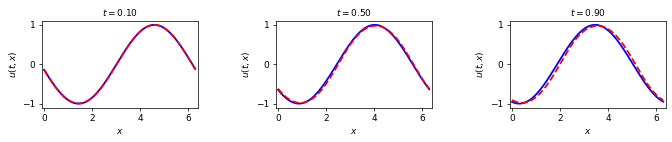

Run = 1, Iteration = 4000
Run = 1, Iteration = 8000
Run = 1, Iteration = 12000
Run = 1, Iteration = 16000
Run = 1, Iteration = 20000
loss: 7.906218e-05
L1 error: 4.207190e-02
L2 error: 4.874135e-02
time elapsed: 100.177


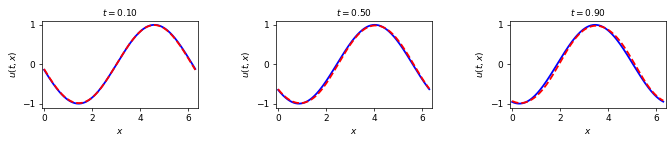

Run = 2, Iteration = 4000
Run = 2, Iteration = 8000
Run = 2, Iteration = 12000
Run = 2, Iteration = 16000
Run = 2, Iteration = 20000
loss: 1.408418e-04
L1 error: 4.435400e-02
L2 error: 5.519758e-02
time elapsed: 100.430


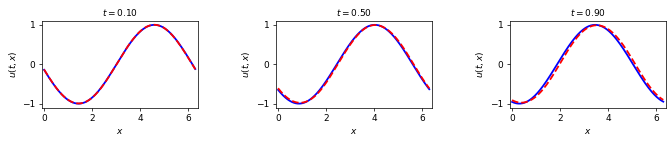

Run = 3, Iteration = 4000
Run = 3, Iteration = 8000
Run = 3, Iteration = 12000
Run = 3, Iteration = 16000
Run = 3, Iteration = 20000
loss: 6.054972e-05
L1 error: 4.373861e-02
L2 error: 5.388403e-02
time elapsed: 100.003


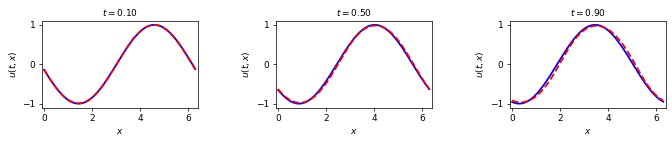

Run = 4, Iteration = 4000


In [ ]:
# main loop

M = 10 # number of repetitions
N = 20000 # number of training iterations
L1_err = np.zeros(M)
L2_err = np.zeros(M)
tm = np.zeros(M)
lr = 0.001
nnets = []

r=0 #repetition counter
#f=0 #failure counter
while r<M:

  nnet = neural_net(layer_sizes)
  opt =  tf.keras.optimizers.Adam(learning_rate=lr,beta_1=.9,beta_2=0.99)

  # data initial condition
  N0 = 200 
  x0 = tf.convert_to_tensor(xlo+(xhi-xlo)*np.random.uniform(size=(N0,1)),dtype=tf.float32)
  t0 = tf.zeros(tf.shape(x0),dtype=tf.float32)
  u0 = np.sin(x0) 
  
  # lower boundary 
  Nb = 1000 
  tlb = tf.convert_to_tensor(tlo+(thi-tlo)*np.random.uniform(size=(Nb,1)),dtype=tf.float32)
  xlb = xlo*tf.ones(tf.shape(tlb),dtype=tf.float32)
  qlb = tf.zeros(tf.shape(tlb),dtype=tf.float32)
  # upper boundary
  tub = tlb 
  xub = xhi*tf.ones(tf.shape(tub),dtype=tf.float32)
  qub = tf.zeros(tf.shape(tub),dtype=tf.float32)  

  for it in range(int(N/4000)):
    start_time = time.time()
    for its in range(4000):
      loss_value,grads = grad(nnet,xlb,tlb,xub,tub,x0,t0,u0)
      opt.apply_gradients(zip(grads,nnet.trainable_variables))
    tm[r] += time.time()-start_time
    print('Run = %d, Iteration = %d' % (r,(it+1)*4000))
    #l1,l2 = results(nnet,loss_value,tm[r])

  #if l2<0.2:
  L1_err[r],L2_err[r] = results(nnet,loss_value,tm[r])
  r = r + 1
  nnets.append(nnet)
  #else:
  #  f = f + 1

In [ ]:
print('L1 error:')
print('mean +/- std = %.4f +/- %.4f' % (np.mean(L1_err),np.std(L1_err)))
print('min -- median -- max = %.4f -- %.4f -- %.4f' % (np.min(L1_err),np.median(L1_err),np.max(L1_err)))
print(L1_err)

print('L2 error:')
print('mean +/- std = %.4f +/- %.4f' % (np.mean(L2_err),np.std(L2_err)))
print('min -- median -- max = %.4f -- %.4f -- %.4f' % (np.min(L2_err),np.median(L2_err),np.max(L2_err)))
print(L2_err)

print('time = %.4f +/- %.4f' % (np.mean(tm),np.std(tm)))

In [ ]:
# Display results

from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

fig = plt.figure(figsize=figsize(3,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.2, right=.9, wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u,interpolation='nearest',cmap='seismic',extent=[0.0,T,0.0,L],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xlabel('$t$',fontsize=20)
ax.set_ylabel('$x$',fontsize=20)
ax.set_title('Exact',fontsize=20)
#fig.savefig('Exact_periodic_v'+str(int(v))+'.png',bbox_inches="tight",facecolor="white")

CINN = nnets[np.argmax(L2_err)](XT_flat)
fig = plt.figure(figsize=figsize(3,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.2, right=.9, wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(np.reshape(CINN,(uxn,utn)).T,interpolation='nearest',cmap='seismic',extent=[0.0,T,0.0,L],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xlabel('$t$',fontsize=20)
ax.set_ylabel('$x$',fontsize=20)
ax.set_title('CINN',fontsize=20)
fig.savefig('CINN_periodic_v'+str(int(v))+'.png',bbox_inches="tight",facecolor="white")

#files.download('Exact_periodic_v'+str(int(v))+'.png')
files.download('CINN_periodic_v'+str(int(v))+'.png')

In [ ]:
f